In [2]:
import networkx as nx
import matplotlib.pyplot as plt

In [35]:
import warnings
warnings.filterwarnings("ignore")

In [205]:
from collections import defaultdict
from copy import copy

In [73]:
def get_ancestors(G, v):
    in_nodes = filter(lambda x: x[1] == v, G.in_edges)
    ancestors = list(map(lambda x: x[0], in_nodes))
    return ancestors    

In [273]:
UNDEFINED = 99999999        
    
def topsorting(G):
    for node in G.nodes.values():
        node['id'] = UNDEFINED

    unused = list(G.nodes())
    topsort = []

    for i in range(len(G.nodes())):            
        min_ancestors = [UNDEFINED]
        min_v = None

        for v in unused:
            if G.nodes()[v].get('id') == UNDEFINED:
                ancestors = sorted([G.nodes()[anc]['id'] for anc in get_ancestors(G, v)], reverse=True)
                if ancestors < min_ancestors:
                    min_ancestors = ancestors
                    min_v = v
        G.nodes()[min_v]['id'] = i
        topsort.append(min_v)
        unused.remove(min_v)

    return topsort

## Алгоритм Грэхема—Коффмана

In [274]:
def solve_grakham(G, w=3):
    topsort = topsorting(G)
    current_layer = 0
    layers = defaultdict(list)
    for v in reversed(topsort):
        if len(layers[current_layer]) == w:
            current_layer += 1                
        if any(map(lambda x: x in layers[current_layer], G[v])):
            current_layer += 1

        layers[current_layer].append(v)
        G.nodes[v]['layer'] = current_layer
    return topsort

In [285]:
def build_layers(G):    
    layers = defaultdict(list)
    for v in G.nodes():
        layers[G.nodes()[v]['layer']].append(v)  
    return layers

In [287]:
def draw_graph(G, layers, filename='g.png'):
    pos = {}
    for y, layer in layers.items():
        for x, v in enumerate(layer):
            pos[v] = (x, y)
    
    fig, ax = plt.subplots(figsize=(15,15))
#     plt.gca().invert_yaxis()
    ax.grid(True)
    
    nx.draw(G, pos, nodelist=list(filter(lambda x: x.startswith('n'), G)),
            with_labels=True, node_size=1000, node_color='#6495ed', ax=ax)    
    nx.draw(G, pos, nodelist=list(filter(lambda x: x.startswith('d'), G)),
            with_labels=True, node_size=1000, node_color='red', ax=ax)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos)
#     ax.invert_yaxis()
#     plt.savefig(filename)

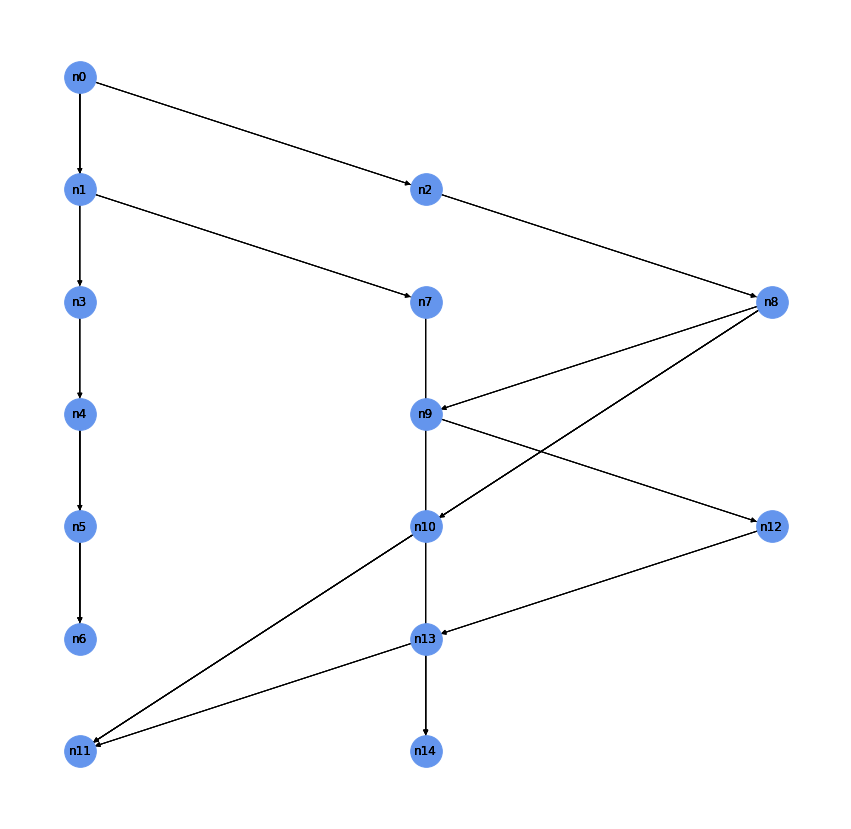

In [288]:
G = nx.read_graphml('samples/small_dag.graphml')
topsort = solve_grakham(G, 3)
layers = build_layers(G)
draw_graph(G, layers)

## Добавление dummy-вершин

In [277]:
def add_dummy(G):
    nodes = list(G.nodes())
    count_dummies = 0
    for v in nodes:
        for u in list(G[v]):
            dist = G.nodes()[v]['layer'] - G.nodes()[u]['layer']
            if dist <= 1:
                continue
            G.remove_edge(v, u)
            from_  = v
            current_layer = G.nodes()[v]['layer'] - 1
            for i in range(dist - 1):
                dummy = 'd{}'.format(count_dummies)
                count_dummies += 1
                current_layer
                G.add_node(dummy)
                G.add_edge(from_, dummy)
                G.nodes()[dummy]['layer'] = current_layer
                current_layer -= 1                
                from_ = dummy            
            G.add_edge(from_, u)    

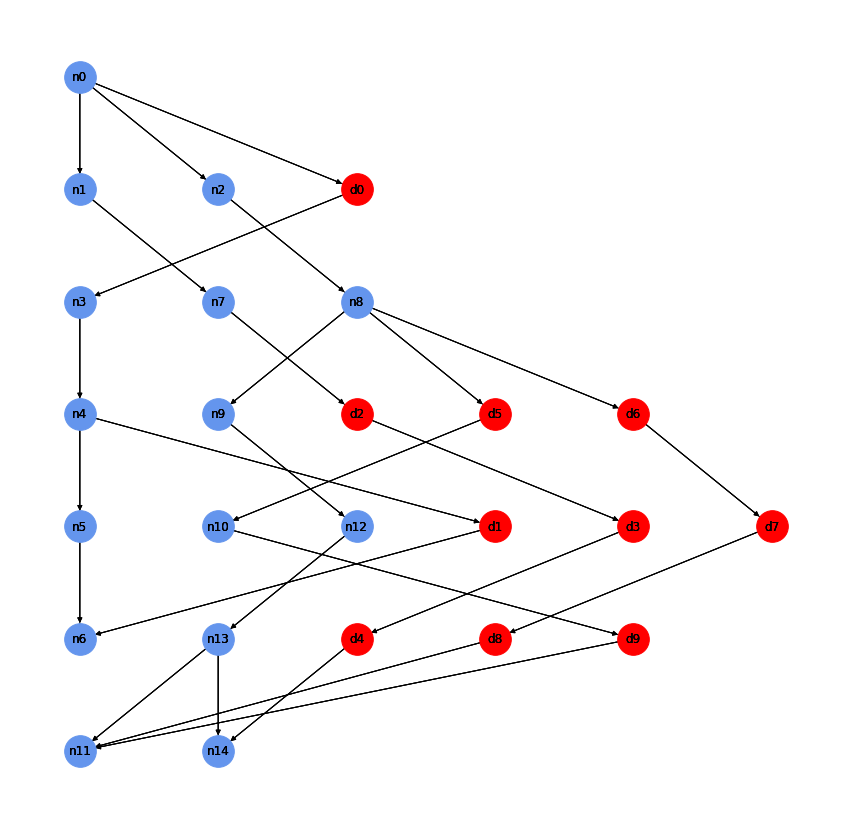

In [289]:
G = nx.read_graphml('samples/small_dag.graphml')
topsort = solve_grakham(G, 3)
add_dummy(G)
layers = build_layers(G)
draw_graph(G, layers)

## Минимизация числа dummy-вершин

In [218]:
from scipy.optimize import linprog

In [247]:
import math

In [281]:
def minization(G, topsort):    
    n = len(G)
    A_ub = []
    b_ub = []  
    c = [0] * n  
    bounds = [(1, None)] * n    
    
    for v in list(G.nodes()):
        for u in list(G[v]):            
            A_ub.append([0] * n)       
            c[G.nodes()[v]['id']] += 1          
            c[G.nodes()[u]['id']] -= 1    
            A_ub[-1][G.nodes()[v]['id']] = -1   
            A_ub[-1][G.nodes()[u]['id']] = 1
            b_ub.append(-1)
    results = linprog(c=c, A_ub=A_ub, b_ub=b_ub, bounds=bounds).x
    opt_layers = {topsort[i]: results[i] for i in range(n)}
    
    for v in reversed(topsort):
        current_layer = opt_layers[v]        
        max_child_layer = G.nodes[(max(list(G[v]), key=lambda u: G.nodes[u]['layer']))]['layer'] if len(G[v]) > 0 else -1        
        
        if max_child_layer >= math.floor(current_layer):
            G.nodes[v]['layer'] = math.ceil(current_layer)
        elif len(G[v]) >= len(get_ancestors(G, v)):
            G.nodes[v]['layer'] = math.floor(current_layer)
        else:
            G.nodes[v]['layer'] = math.ceil(current_layer)

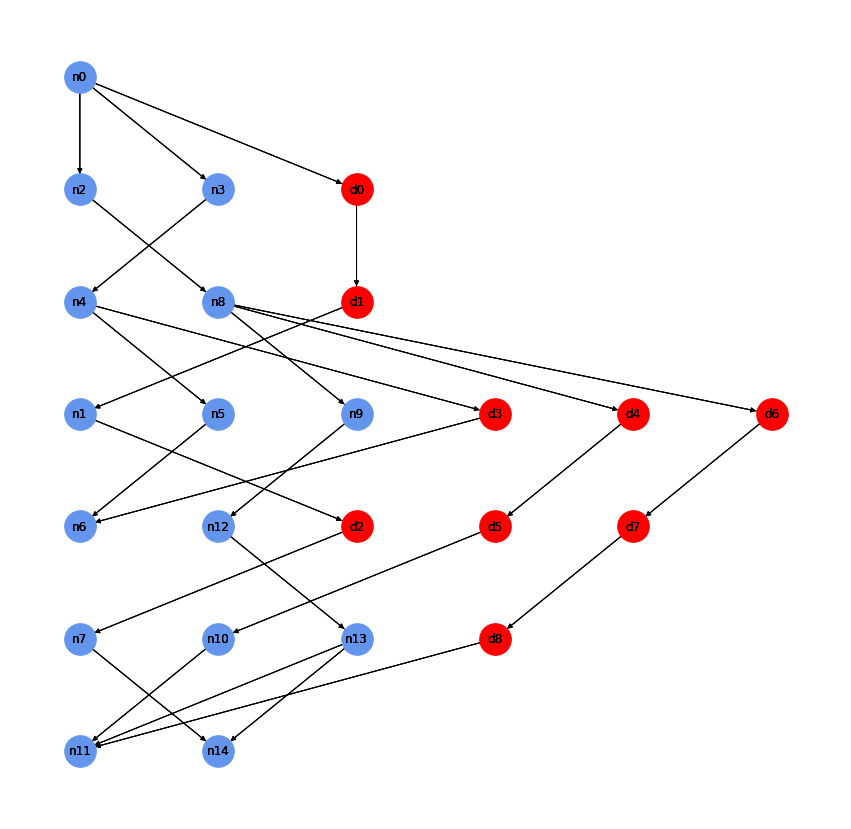

In [291]:
G = nx.read_graphml('samples/small_dag.graphml')
topsort = topsort_grakham(G)
minization(G, topsort)
add_dummy(G)
layers = build_layers(G)
draw_graph(G, layers)

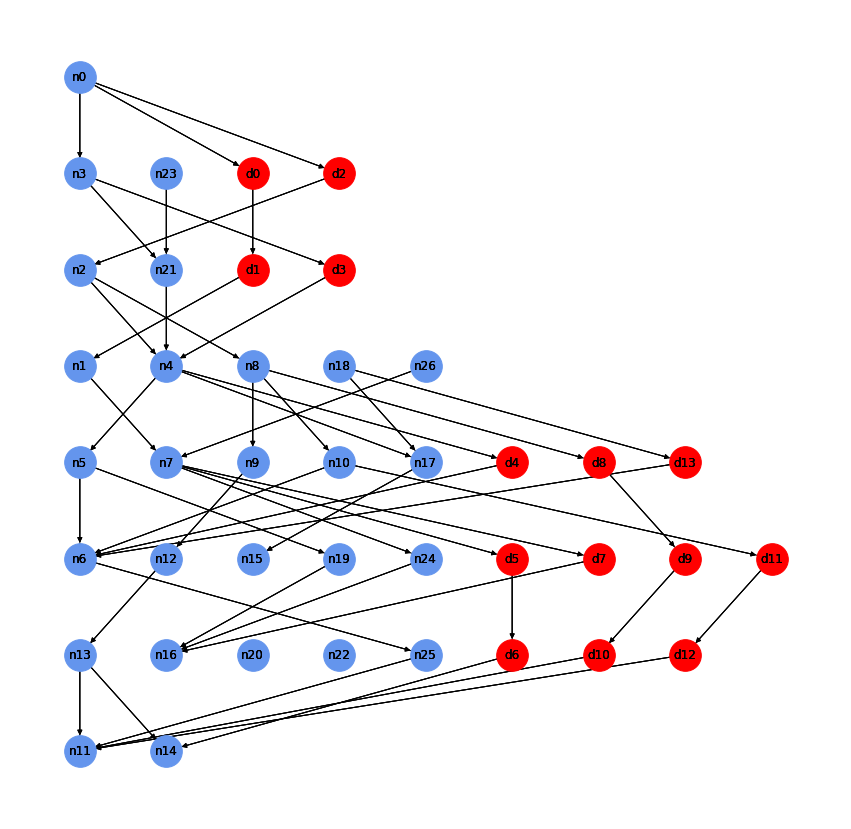

In [292]:
G = nx.read_graphml('samples/big_dag.graphml')
topsort = topsort_grakham(G)
minization(G, topsort)
add_dummy(G)
layers = build_layers(G)
draw_graph(G, layers)

## Минимизация пересечений

In [ ]:
from statistics import median

In [317]:
def minimize_crossing_median(G, layers):
    new_layers = {}
    sorted(layers.keys(), reverse=True)
    for i in sorted(layers.keys(), reverse=True):
        layer = layers[i]
        edges_poses = defaultdict(list)
        for j, v in enumerate(layer):
            for u in G[v]:
                edges_poses[u].append(i)
        median_poses = {}
        for v, poses in edges_poses.items():
            median_poses[v] = int(median(poses))
        new_layer_pairs = sorted([(median_poses.get(v, UNDEFINED), v) for v in layer])
        new_layers[i] = [data[1] for data in new_layer_pairs]
    return new_layers

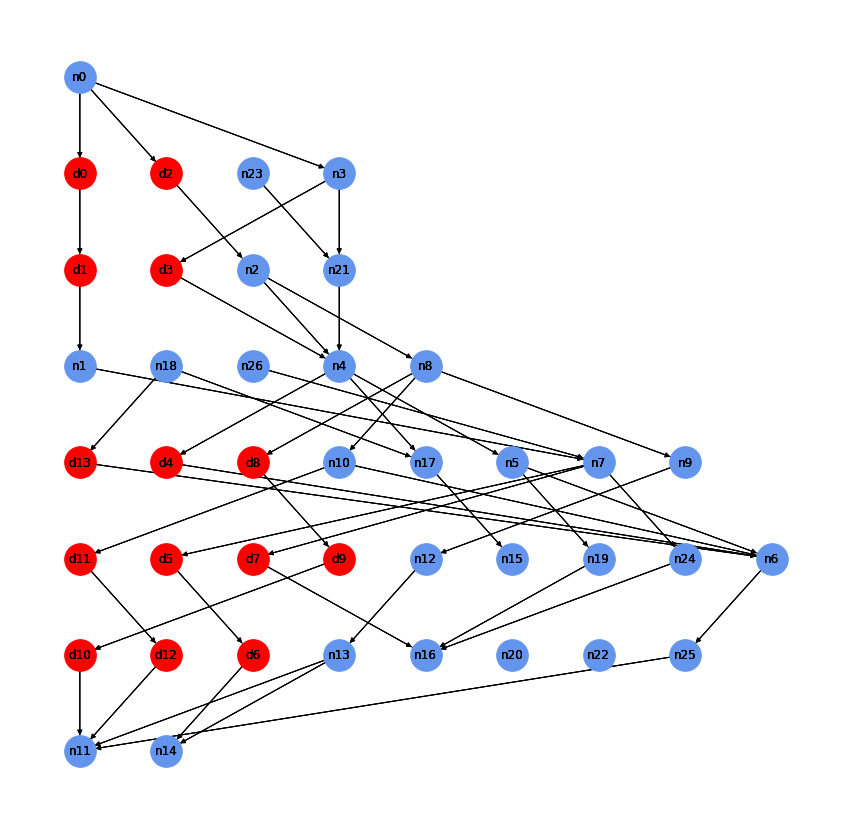

In [321]:
min_layer = minimize_crossing_median(G, layers)
draw_graph(G, min_layer)